In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from utils import *




In [16]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import welch

def load_and_visualize_subject_data(base_dir, subject_id=None, level=None):
    # Convert subject_id to string if provided
    if subject_id is not None:
        subject_id = str(subject_id)

    # Get list of all participants
    modalities = ['EEG', 'ECG', 'EDA', 'Gaze']
    
    # Initialize participant_ids
    participant_ids = []
    
    # Check EEG directory for participant list
    eeg_dir = os.path.join(base_dir, 'EEG')
    if os.path.isdir(eeg_dir):
        participant_ids = [d for d in os.listdir(eeg_dir) 
                         if os.path.isdir(os.path.join(eeg_dir, d))]
    
    if not participant_ids:
        print("No participants found in EEG directory.")
        return

    # Select participant
    if subject_id is None:
        subject_id = random.choice(participant_ids)
    elif subject_id not in participant_ids:
        print(f"Participant '{subject_id}' not found. Using random participant.")
        subject_id = random.choice(participant_ids)

    # Select level
    available_levels = list(range(1, 10))  # Levels 1-9
    if level is None:
        level = random.choice(available_levels)
    elif level not in available_levels:
        print(f"Level {level} not valid. Using random level.")
        level = random.choice(available_levels)

    print(f"Visualizing data for participant: {subject_id}, Level: {level}")

    def plot_eeg_with_psd(data, time, ax_time, ax_psd, title):
        # Time domain plot
        for col in data.columns[1:]:
            ax_time.plot(time, data[col], label=col, alpha=0.7)
        
        # Calculate sampling rate
        sampling_rate = 1 / (time[1] - time[0])
        
        # PSD analysis using Welch's method
        for col in data.columns[1:]:
            signal = data[col].values
            frequencies, psd = welch(signal, fs=sampling_rate, nperseg=min(256, len(signal)),
                                   scaling='density')
            
            # Plot only up to 200 Hz
            mask = frequencies <= 200
            ax_psd.semilogy(frequencies[mask], psd[mask], label=col, alpha=0.7)
        
        ax_psd.set_xlabel('Frequency (Hz)')
        ax_psd.set_ylabel('Power Spectral Density (µV²/Hz)')
        ax_psd.set_title(f'Power Spectral Density - {title}')
        if len(data.columns[1:]) <= 10:  # Only show legend if not too many channels
            ax_psd.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax_psd.grid(True, alpha=0.3)
        
        # Add vertical lines for different frequency bands
        band_colors = {'Delta (0.5-4 Hz)': 'gray', 
                      'Theta (4-8 Hz)': 'lightblue',
                      'Alpha (8-13 Hz)': 'green',
                      'Beta (13-30 Hz)': 'red',
                      'Gamma (30-100 Hz)': 'purple'}
        
        for band, (start, end) in {'Delta': (0.5, 4), 'Theta': (4, 8), 
                                  'Alpha': (8, 13), 'Beta': (13, 30),
                                  'Gamma': (30, 100)}.items():
            ax_psd.axvspan(start, end, color=band_colors[f'{band} ({start}-{end} Hz)'], 
                          alpha=0.1, label=f'{band} band')

    # Visualize data for each modality
    for modality in modalities:
        if modality == 'EEG':
            # Create figure with 4 subplots for EEG: time and PSD for both task and baseline
            plt.figure(figsize=(15, 12))
            ax_time_task = plt.subplot(411)
            ax_psd_task = plt.subplot(412)
            ax_time_baseline = plt.subplot(413)
            ax_psd_baseline = plt.subplot(414)
        else:
            plt.figure(figsize=(15, 8))
            ax1 = plt.subplot(211)
            ax2 = plt.subplot(212)
        
        modality_dir = os.path.join(base_dir, modality, subject_id)
        
        if not os.path.exists(modality_dir):
            print(f"No {modality} data found for participant {subject_id}")
            plt.close()
            continue

        # Load and plot data
        data_file = os.path.join(modality_dir, f"{modality.lower()}_data_level_{level}.csv")
        baseline_file = os.path.join(modality_dir, f"{modality.lower()}_baseline_level_{level}.csv")
        
        try:
            main_data = pd.read_csv(data_file)
            baseline_data = pd.read_csv(baseline_file)
            
            time_main = main_data.iloc[:, 0]  # Assuming first column is time
            time_baseline = baseline_data.iloc[:, 0]
            
            if modality == 'EEG':
                # Plot EEG data with PSD
                plot_eeg_with_psd(main_data, time_main, ax_time_task, ax_psd_task, "Task Data")
                plot_eeg_with_psd(baseline_data, time_baseline, ax_time_baseline, ax_psd_baseline, "Baseline Data")
                
                ax_time_task.set_title(f"EEG Task Data - Time Domain - Participant {subject_id} - Level {level}")
                ax_time_baseline.set_title(f"EEG Baseline Data - Time Domain - Participant {subject_id} - Level {level}")
                
                for ax in [ax_time_task, ax_time_baseline]:
                    ax.set_xlabel("Time (s)")
                    ax.set_ylabel("Amplitude (µV)")
                    if len(main_data.columns[1:]) <= 10:
                        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                    ax.grid(True, alpha=0.3)
                
            elif modality == 'ECG':
                # Line plots for ECG
                for col in main_data.columns[1:]:
                    ax1.plot(time_main, main_data[col], label=col, alpha=0.7)
                for col in baseline_data.columns[1:]:
                    ax2.plot(time_baseline, baseline_data[col], label=col, alpha=0.7)
                
                ax1.set_title(f"ECG Task Data - Participant {subject_id} - Level {level}")
                ax2.set_title(f"ECG Baseline Data - Participant {subject_id} - Level {level}")
                
            elif modality == 'EDA':
                # Combined line and scatter for EDA
                for col in main_data.columns[1:]:
                    ax1.plot(time_main, main_data[col], label=col, alpha=0.7)
                    ax1.scatter(time_main, main_data[col], s=5, alpha=0.3)
                for col in baseline_data.columns[1:]:
                    ax2.plot(time_baseline, baseline_data[col], label=col, alpha=0.7)
                    ax2.scatter(time_baseline, baseline_data[col], s=5, alpha=0.3)
                
                ax1.set_title(f"EDA Task Data - Participant {subject_id} - Level {level}")
                ax2.set_title(f"EDA Baseline Data - Participant {subject_id} - Level {level}")
                
            elif modality == 'Gaze':
                if 'Gaze X' in main_data.columns and 'Gaze Y' in main_data.columns:
                    # Task data heatmap
                    valid_df = main_data[['Gaze X', 'Gaze Y']].dropna()
                    if not valid_df.empty:
                        heatmap, xedges, yedges = np.histogram2d(
                            valid_df['Gaze X'], valid_df['Gaze Y'], bins=30)
                        im1 = ax1.imshow(heatmap.T, origin='lower', cmap='hot',
                                       extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
                        plt.colorbar(im1, ax=ax1, label='Gaze Frequency')
                    
                    # Baseline data heatmap
                    valid_df_baseline = baseline_data[['Gaze X', 'Gaze Y']].dropna()
                    if not valid_df_baseline.empty:
                        heatmap, xedges, yedges = np.histogram2d(
                            valid_df_baseline['Gaze X'], valid_df_baseline['Gaze Y'], bins=30)
                        im2 = ax2.imshow(heatmap.T, origin='lower', cmap='hot',
                                       extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
                        plt.colorbar(im2, ax=ax2, label='Gaze Frequency')
                
                ax1.set_title(f"Gaze Task Data - Participant {subject_id} - Level {level}")
                ax2.set_title(f"Gaze Baseline Data - Participant {subject_id} - Level {level}")

            # Common formatting for non-EEG modalities
            if modality != 'EEG':
                for ax in [ax1, ax2]:
                    ax.grid(True, alpha=0.3)
                    ax.set_xlabel("Time (s)")
                    if modality != 'Gaze':
                        if len(main_data.columns[1:]) <= 10:
                            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                        ax.set_ylabel("Amplitude")

            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error processing {modality} data for level {level}: {str(e)}")
            plt.close()
            continue

    # Load and plot labels if available
    labels_file = os.path.join(base_dir, 'Labels', f"{subject_id}.csv")
    if os.path.exists(labels_file):
        try:
            labels_data = pd.read_csv(labels_file)
            
            plt.figure(figsize=(15, 6))
            plt.title(f"Labels - Participant {subject_id}")
            
            time = labels_data.iloc[:, 0]
            for col in labels_data.columns[1:]:
                plt.plot(time, labels_data[col], label=col, alpha=0.7)
            
            plt.xlabel("Time (s)")
            plt.ylabel("Label Value")
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error processing labels data: {str(e)}")

Visualizing data for participant: 1716, Level: 7


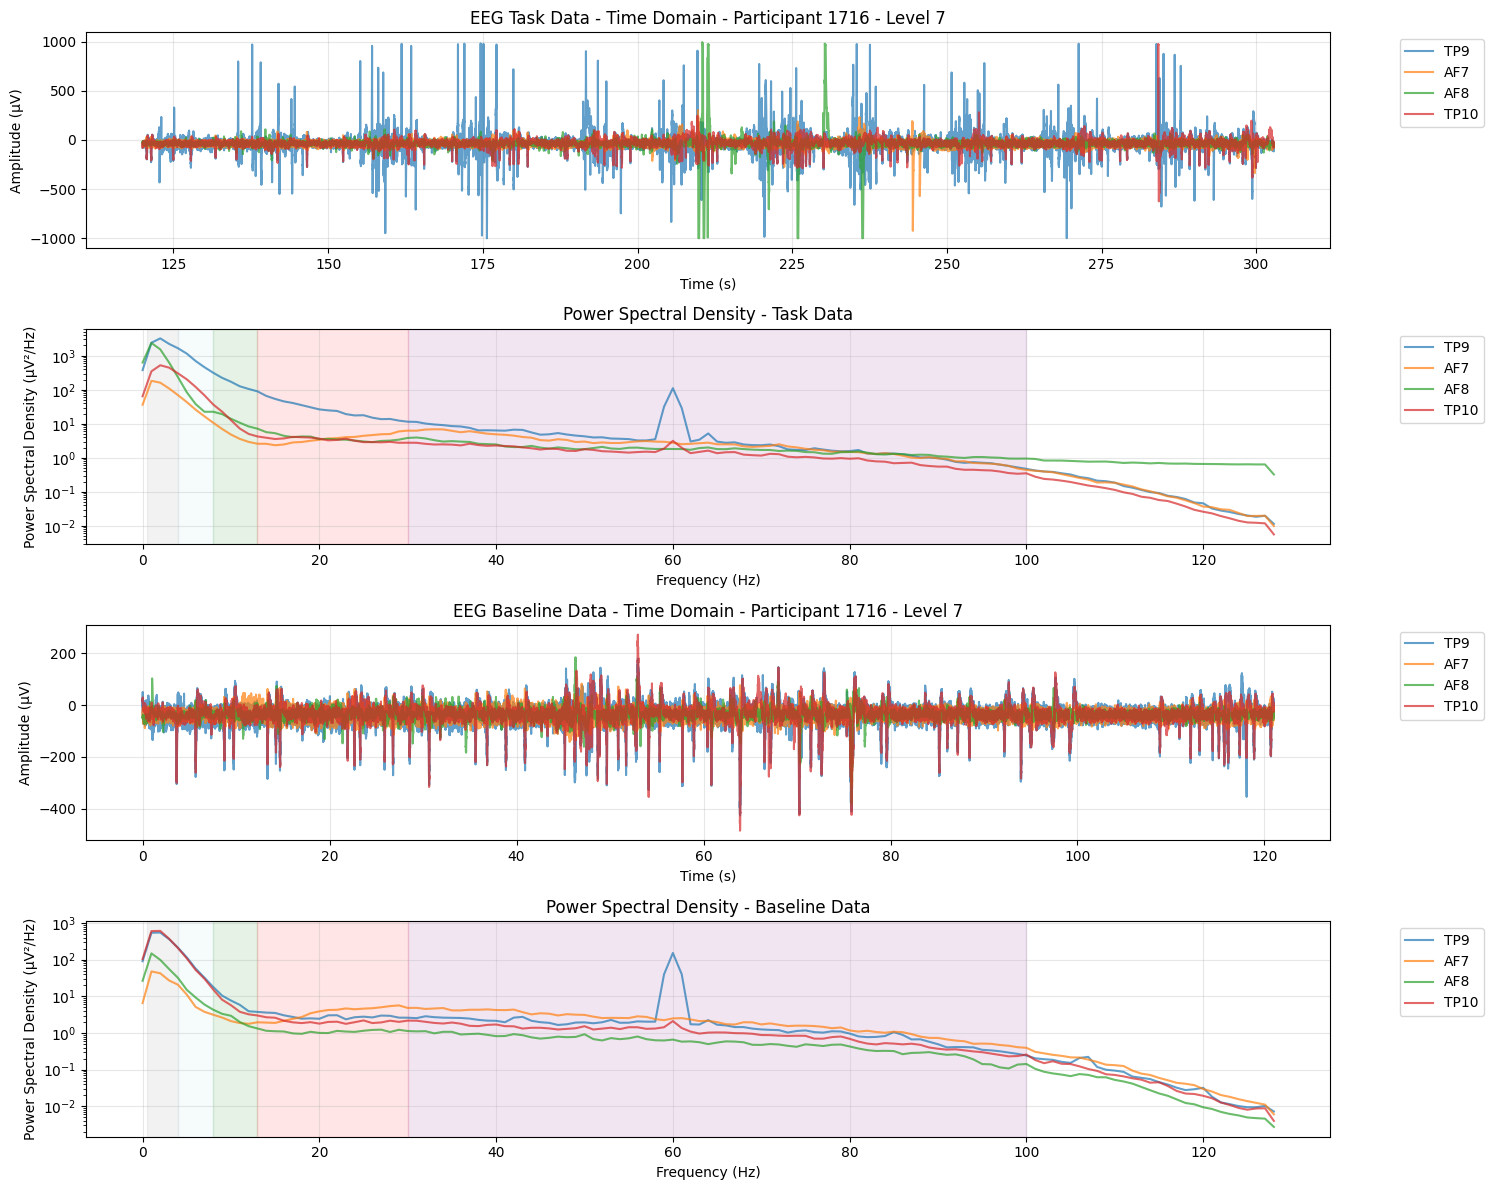

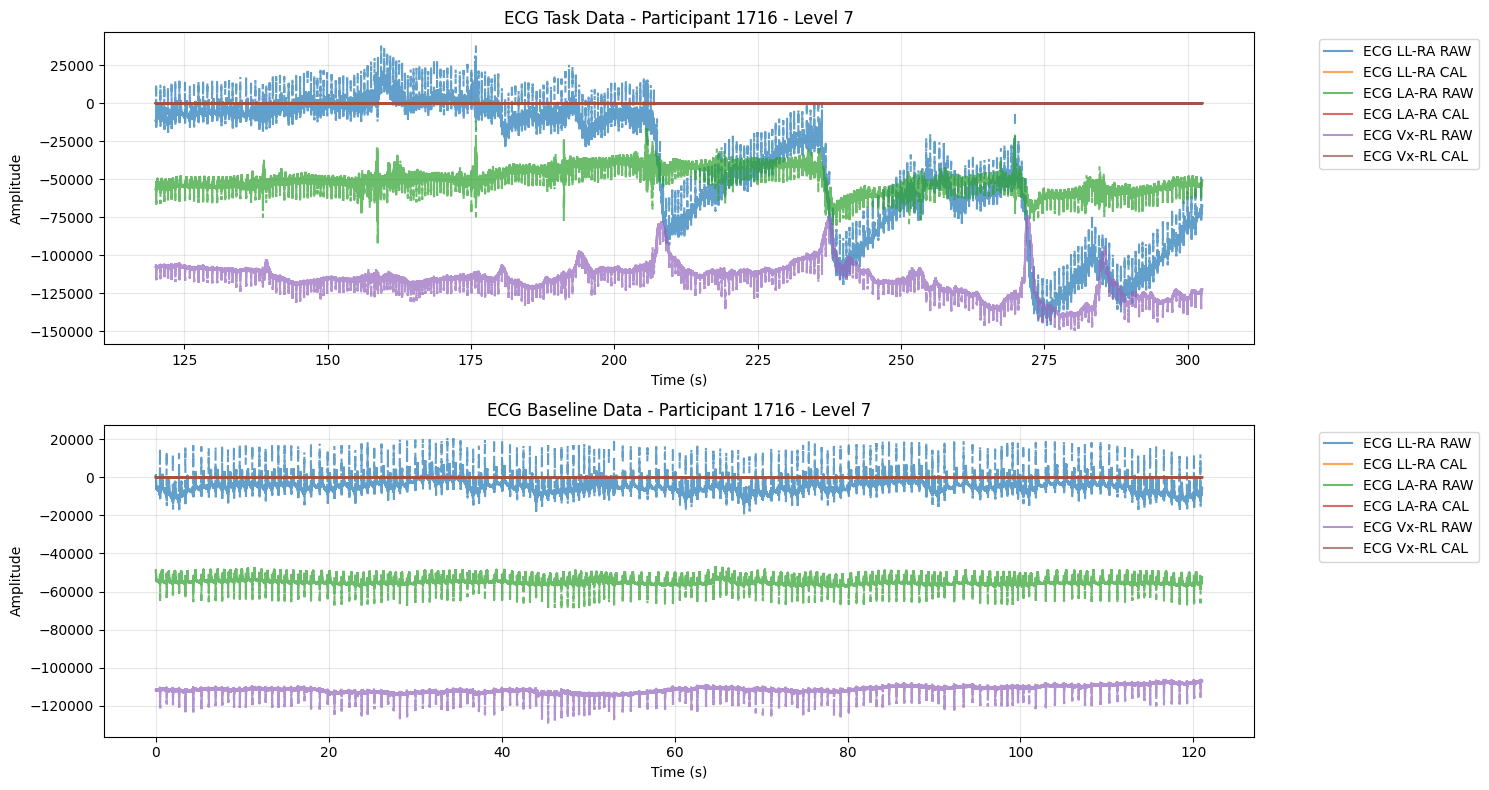

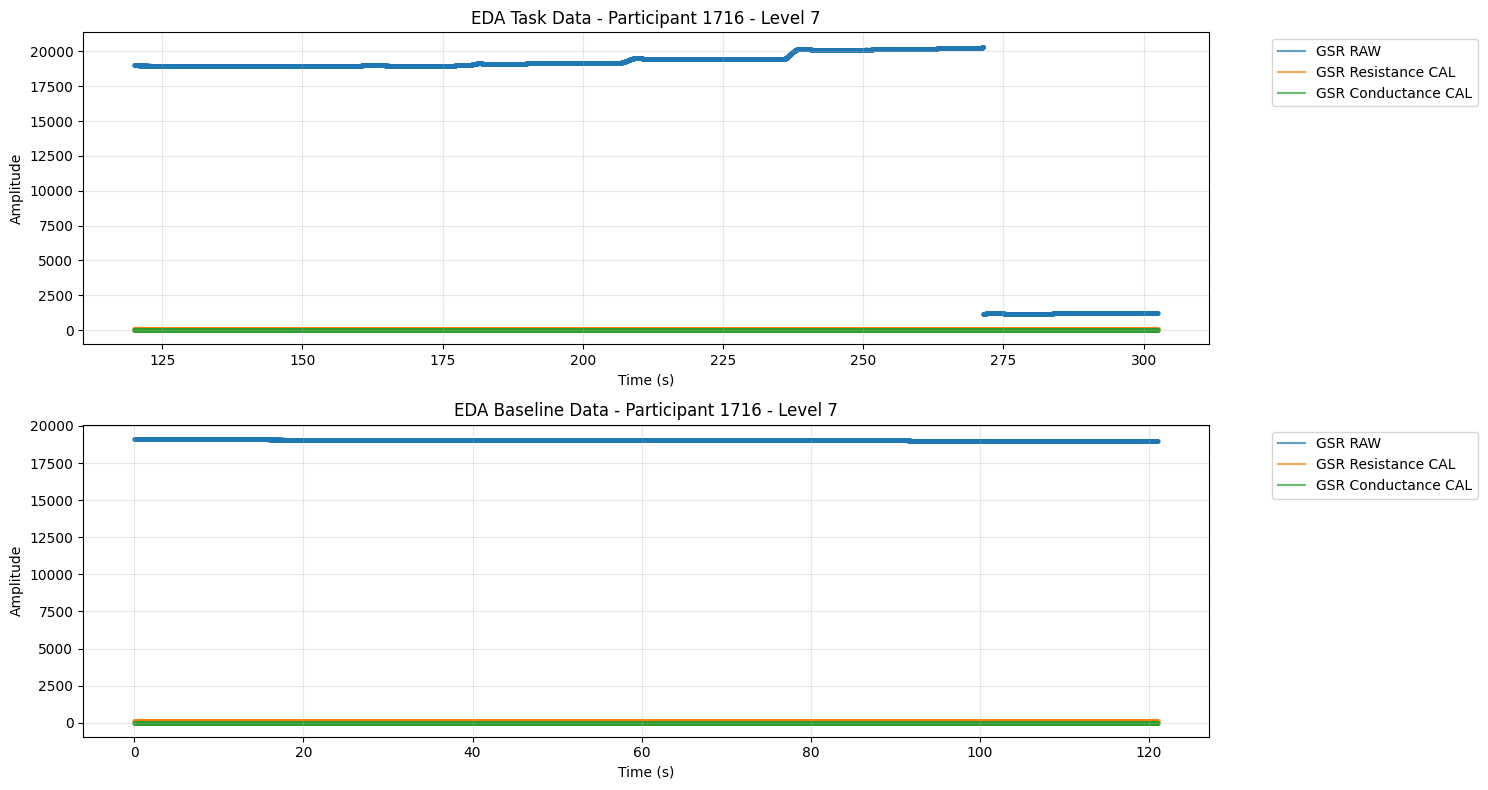

Error processing Gaze data for level 7: [Errno 2] No such file or directory: '../cl_drive/Gaze\\1716\\gaze_data_level_7.csv'


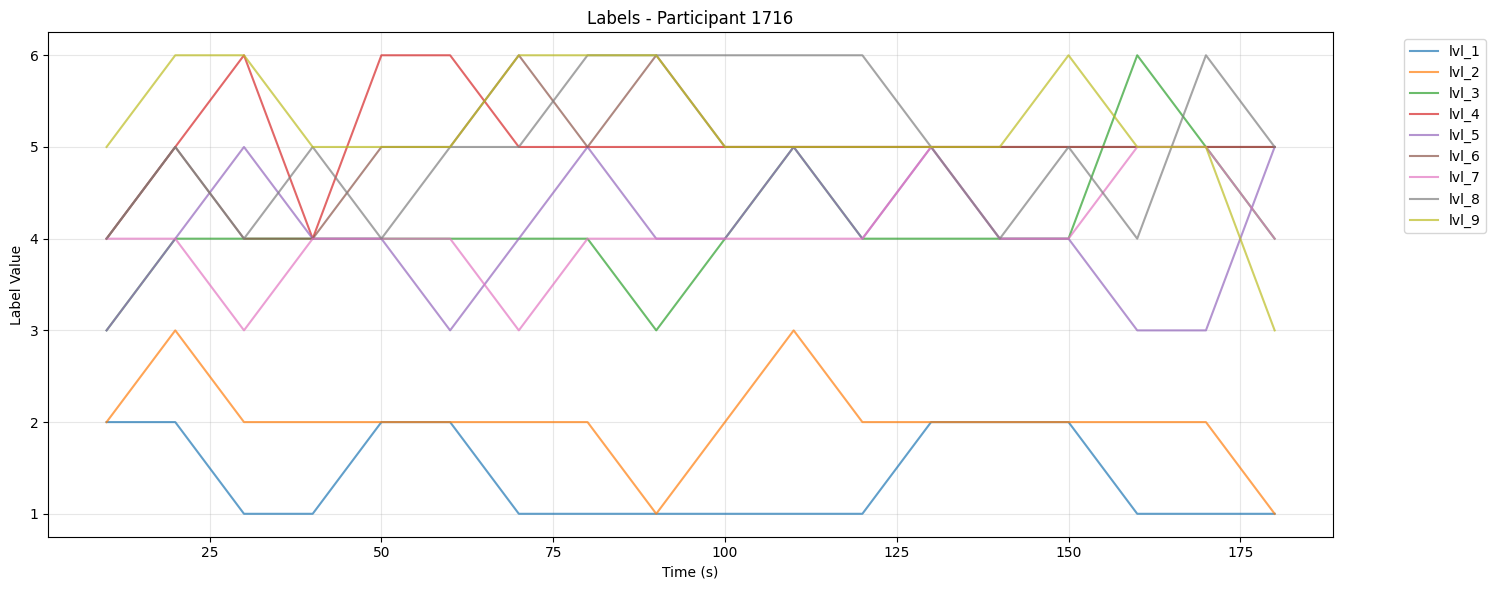

Visualizing data for participant: 1717, Level: 8


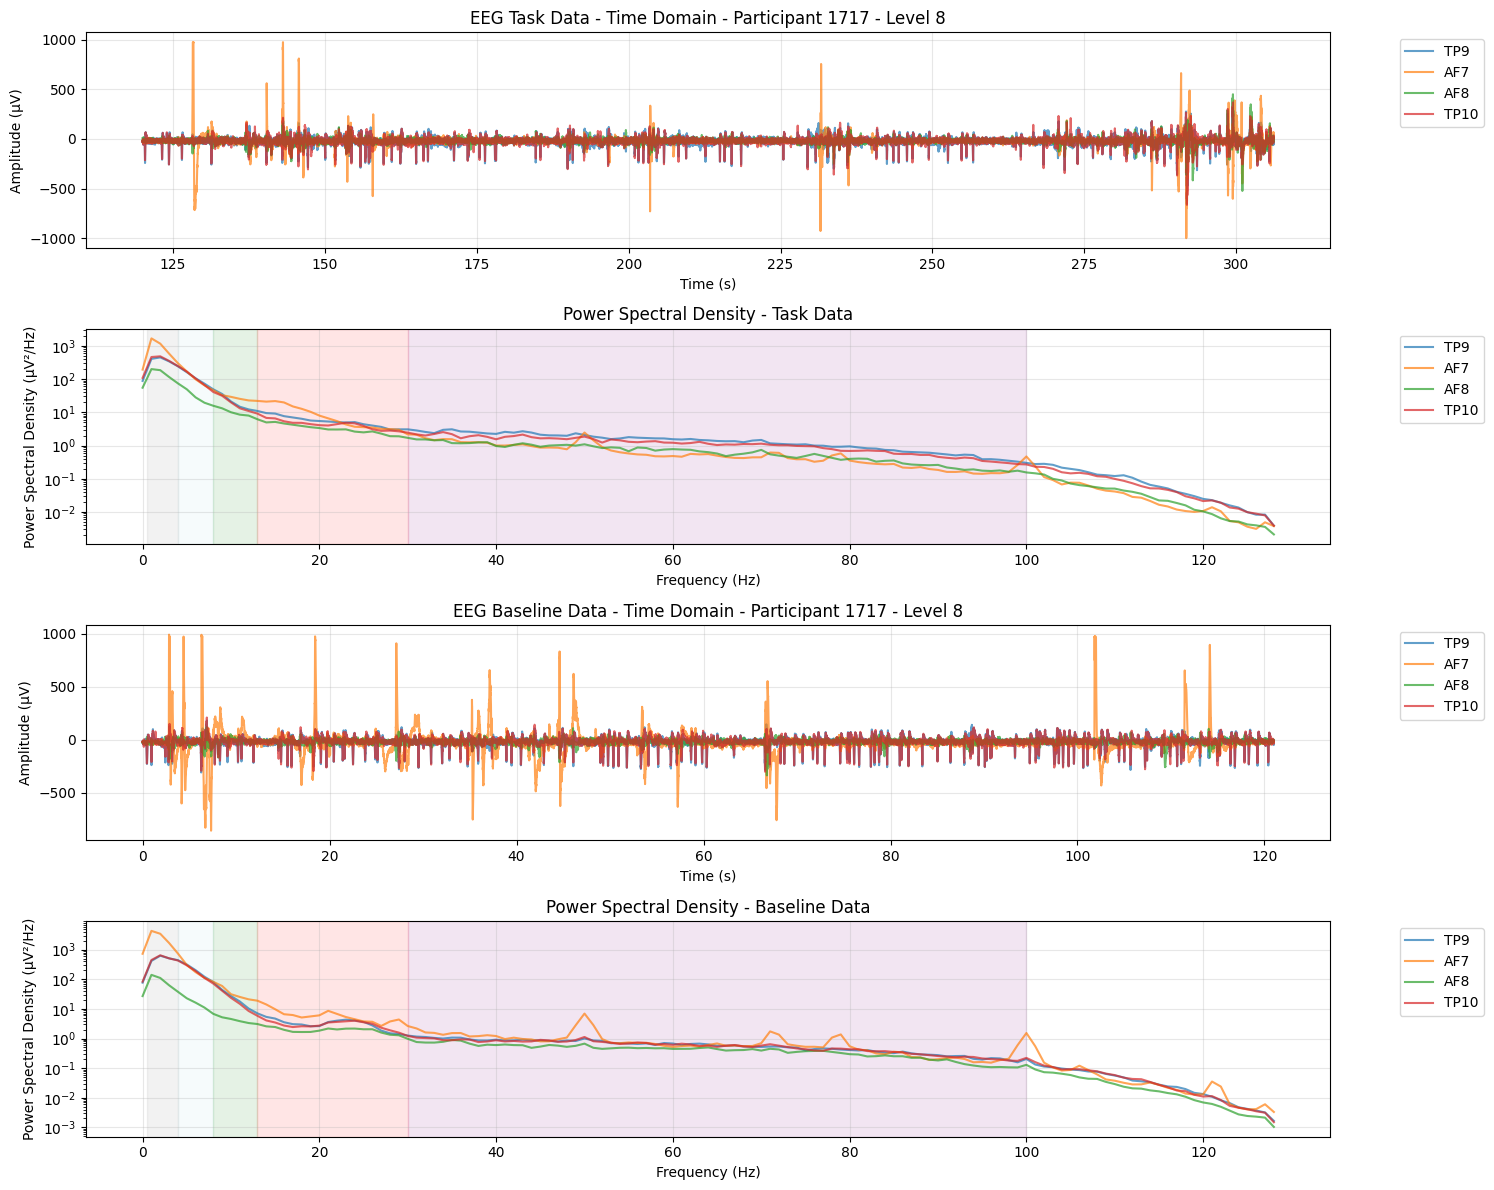

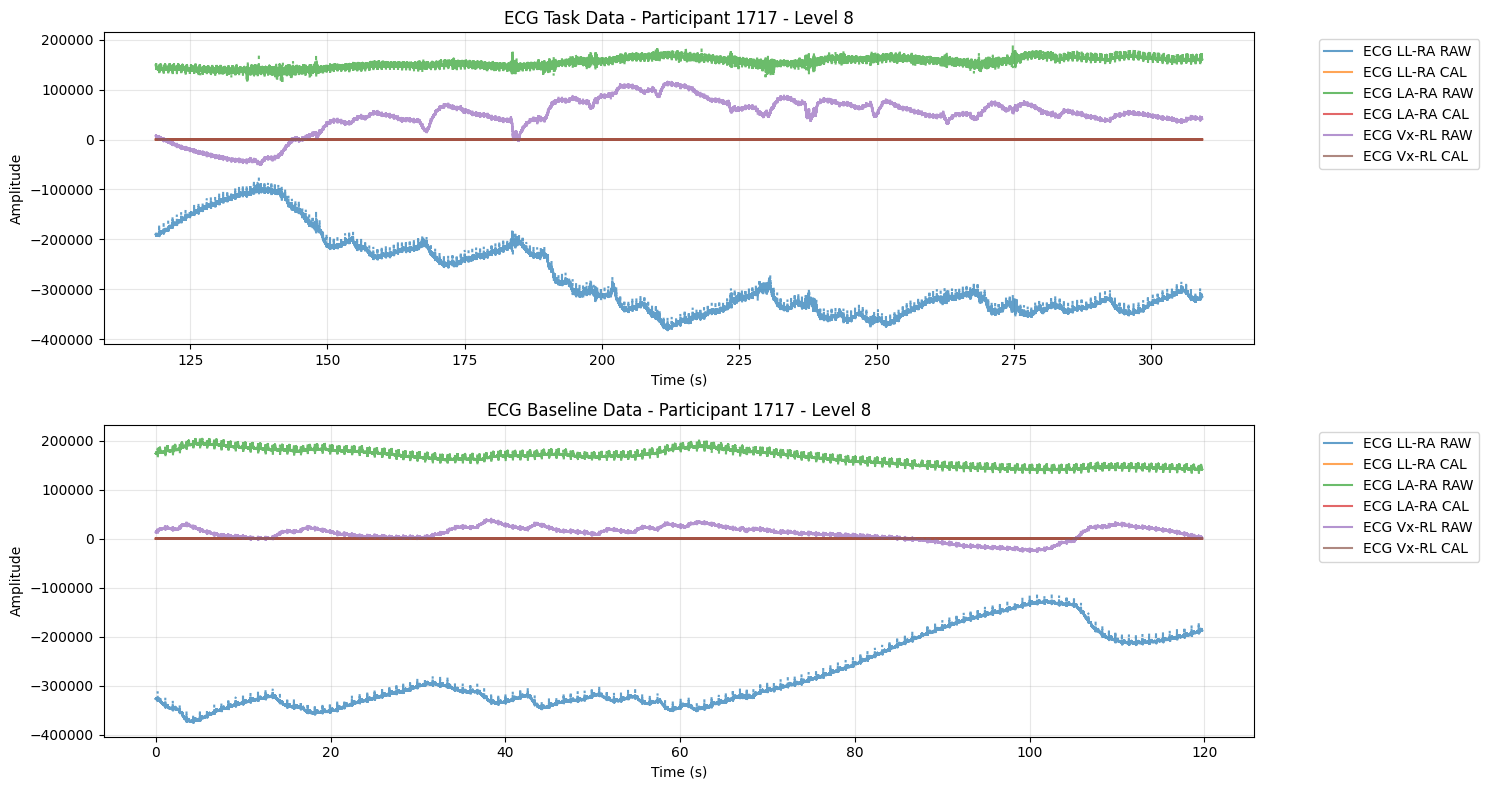

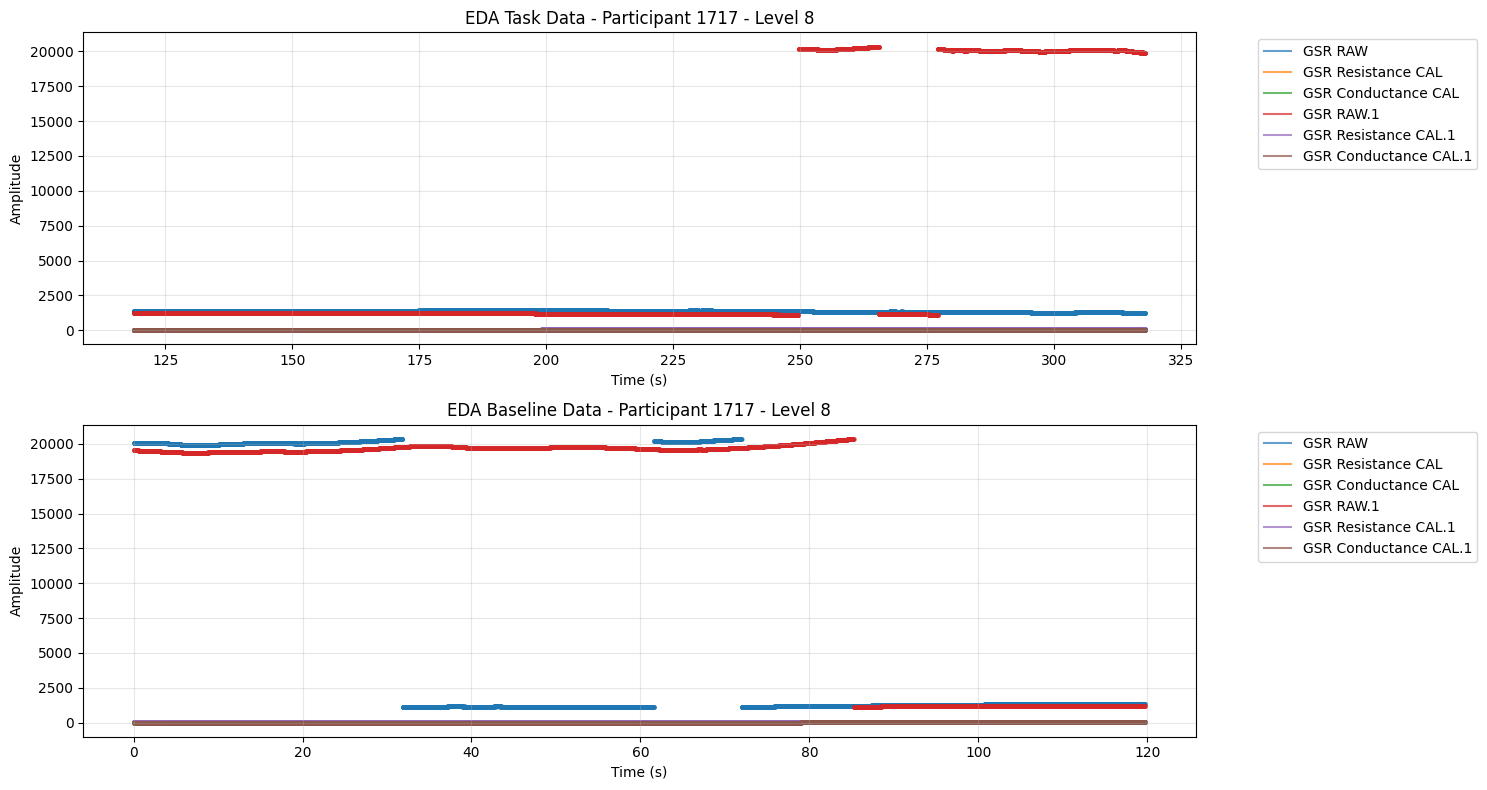

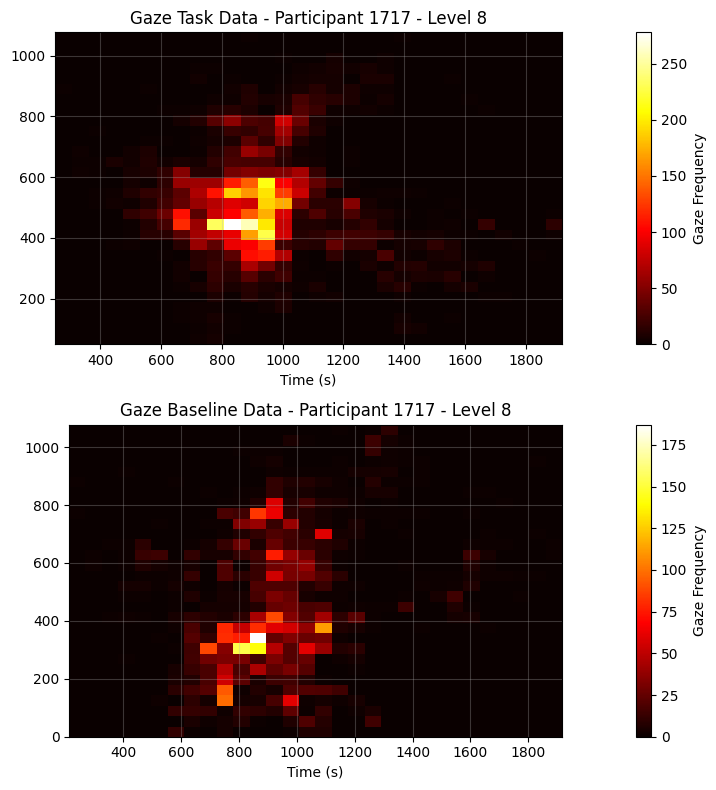

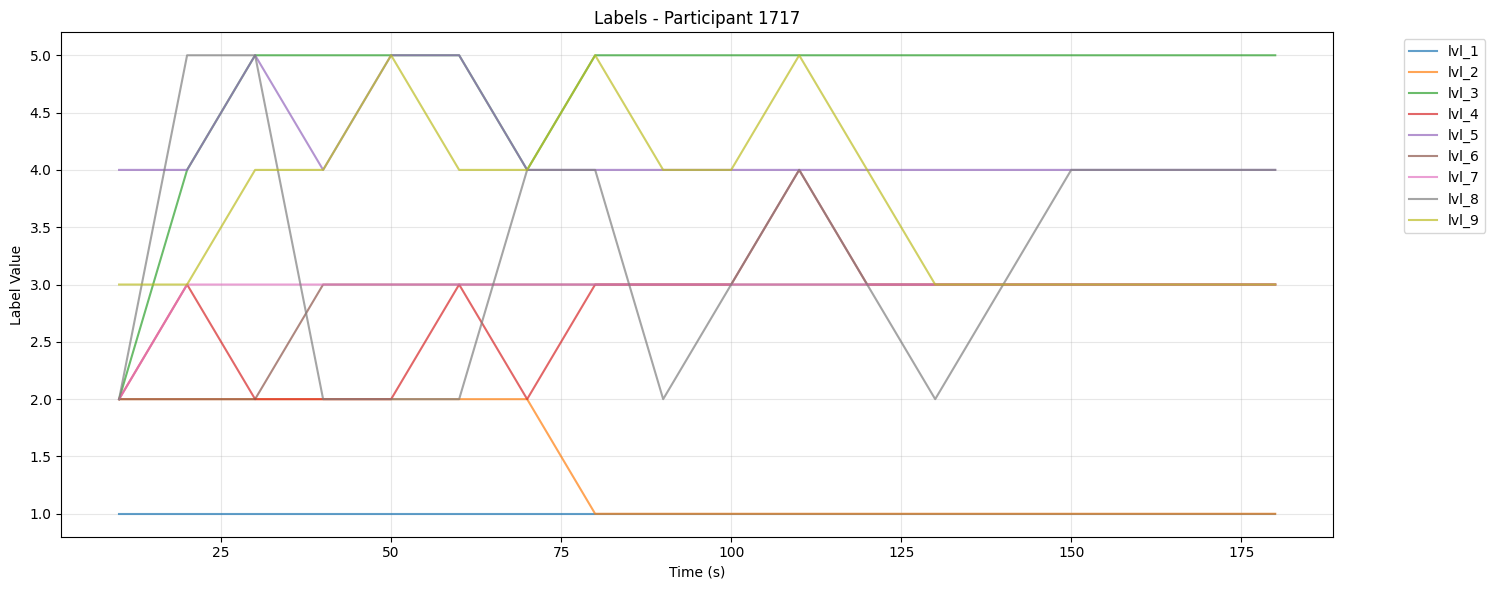

In [23]:


base_dir = '../cl_drive/' 


# Visualize a random participant’s data
load_and_visualize_subject_data(base_dir, subject_id=None)
# Or specify a particular participant (e.g., '1030')
load_and_visualize_subject_data(base_dir, subject_id='1717',level=8)

